<a href="https://colab.research.google.com/github/anhdo1896/Stock_Price_Prediction_Using_RNN/blob/main/Stock_Price_Prediction_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os, time
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import yfinance as yf
yf.pdr_override()

# Deep Learning imports
import tensorflow as tf
import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
2.14.0
[]


In [ ]:
company = 'GOOG'
startdate = dt.datetime(2012, 1, 1)
enddate = dt.datetime(2024, 1, 1)
data = yf.download(company, start=startdate, end=enddate)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2979 entries, 2012-01-03 to 2023-11-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2979 non-null   float64
 1   High       2979 non-null   float64
 2   Low        2979 non-null   float64
 3   Close      2979 non-null   float64
 4   Adj Close  2979 non-null   float64
 5   Volume     2979 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 162.9 KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2979.000000,2979.000000,2979.000000,2979.000000,2979.000000,2.979000e+03
mean,59.703377,60.333019,59.109570,59.734196,59.734196,4.411714e+07
std,38.092274,38.559025,37.670674,38.114791,38.114791,3.519713e+07
min,13.956189,14.060299,13.861045,13.924059,13.924059,1.584340e+05
25%,28.053786,28.305882,27.821790,27.998970,27.998970,2.431600e+07
50%,50.950001,51.632500,50.402500,51.000000,51.000000,3.193800e+07
75%,86.637249,87.725250,85.875500,86.767250,86.767250,5.142400e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,4.995615e+08


In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
data.shape

(2979, 6)

In [ ]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
data = data.loc[:,["Open"]].values
data = data.reshape(data.shape[0],1)

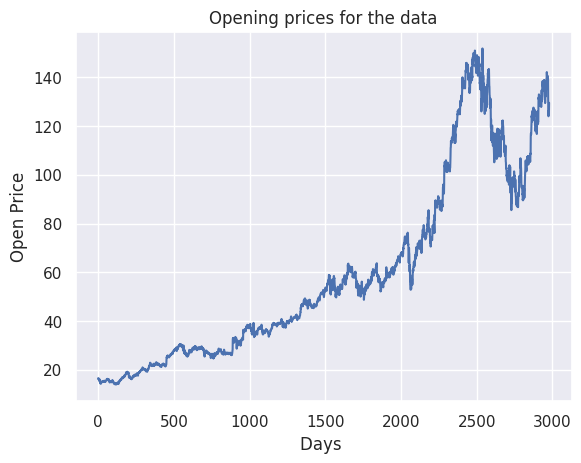

In [ ]:
plt.plot(data);
plt.title("Opening prices for the data");
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.show()

#Normalization / Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    df = min_max_scaler.fit_transform(df.reshape(-1,1))

    return df, min_max_scaler

def load_data(stock, seq_len):
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(stock) - seq_len):
        data.append(stock[index: index + seq_len])

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);


    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]

    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

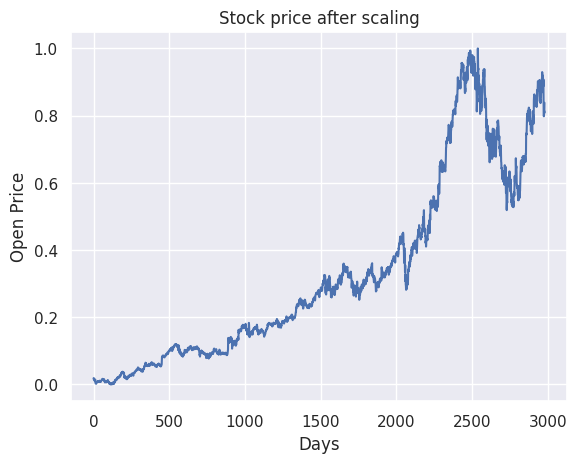

In [ ]:
# normalize stock
df_norm = data.copy()
df_norm, min_max_scaler = normalize_data(df_norm)

plt.plot(df_norm)
plt.xlabel("Days")
plt.ylabel("Open Price")
plt.title("Stock price after scaling")
plt.show()

# Creating X_train and y_train from scaled Train data

In [ ]:
# create train, test data
seq_len = 20 # choose sequence length
X_train, y_train, X_valid, y_valid,X_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2367, 19, 1)
y_train.shape =  (2367, 1)
X_valid.shape =  (296, 19, 1)
y_valid.shape =  (296, 1)
X_test.shape =  (296, 19, 1)
y_test.shape =  (296, 1)


# Creating RNN model

In [ ]:
# --- RNN ---
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

model = Sequential()

# Adding the first RNN layer and Dropout regularisation
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model.add(Dropout(0.2))

# Adding a third RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
simple_rnn_history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
74/74 [==============================] - 7s 43ms/step - loss: 0.2999
Epoch 2/100
74/74 [==============================] - 3s 40ms/step - loss: 0.1075
Epoch 3/100
74/74 [==============================] - 4s 49ms/step - loss: 0.0532
Epoch 4/100
74/74 [==============================] - 4s 49ms/step - loss: 0.0328
Epoch 5/100
74/74 [==============================] - 5s 62ms/step - loss: 0.0232
Epoch 6/100
74/74 [==============================] - 4s 51ms/step - loss: 0.0173
Epoch 7/100
74/74 [==============================] - 3s 43ms/step - loss: 0.0137
Epoch 8/100
74/74 [==============================] - 5s 62ms/step - loss: 0.0112
Epoch 9/100
74/74 [==============================] - 3s 40ms/step - loss: 0.0087
Epoch 10/100
74/74 [==============================] - 2s 27ms/step - loss: 0.0075
Epoch 11/100
74/74 [==============================] - 2s 22ms/step - loss: 0.0060
Epoch 12/100
74/74 [==============================] - 2s 22ms/step - loss: 0.0055
Epoch 13/100
74/74 [=====

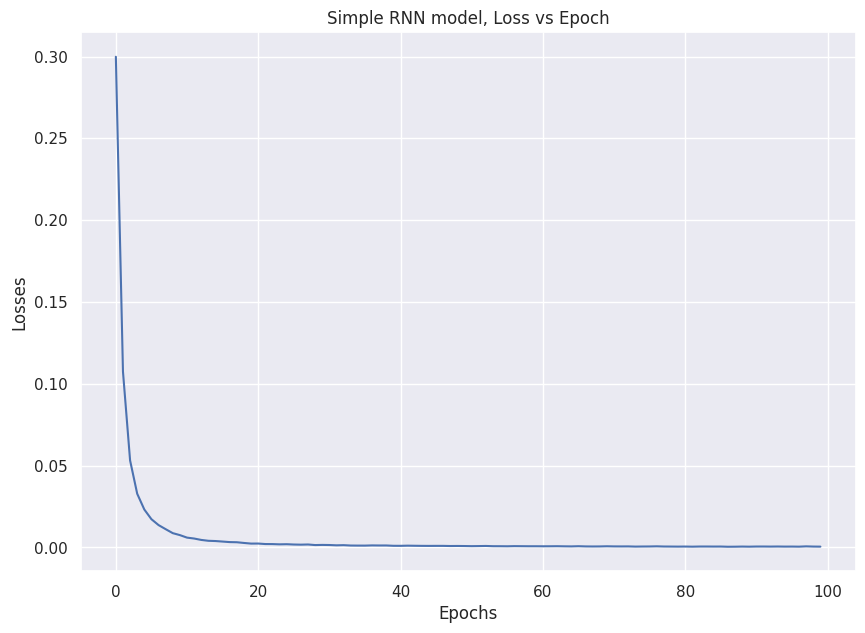

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(simple_rnn_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [ ]:
predicted_data_valid = model.predict(X_valid)
predicted_data_valid = min_max_scaler.inverse_transform(predicted_data_valid)
y_valid = min_max_scaler.inverse_transform(y_valid)

10/10 [==============================] - 1s 8ms/step


In [ ]:
rmse = np.sqrt(np.mean(((predicted_data_valid - y_valid) ** 2)))
print("rmse validation set: ", rmse)

rmse validation set:  6.020437035320015


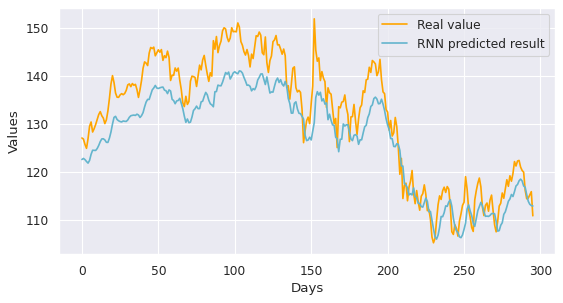

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="orange",label="Real value")
plt.plot(predicted_data_valid,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# Creating LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

model1 = Sequential()
model1.add(LSTM(10, input_shape=(None,1)))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error",optimizer='Adam')
lstm_history=model1.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50
2367/2367 [==============================] - 17s 6ms/step - loss: 8.0255e-04
Epoch 2/50
2367/2367 [==============================] - 20s 8ms/step - loss: 1.6022e-04
Epoch 3/50
2367/2367 [==============================] - 15s 6ms/step - loss: 1.3604e-04
Epoch 4/50
2367/2367 [==============================] - 14s 6ms/step - loss: 1.0973e-04
Epoch 5/50
2367/2367 [==============================] - 14s 6ms/step - loss: 9.8718e-05
Epoch 6/50
2367/2367 [==============================] - 14s 6ms/step - loss: 8.3817e-05
Epoch 7/50
2367/2367 [==============================] - 14s 6ms/step - loss: 7.8165e-05
Epoch 8/50
2367/2367 [==============================] - 14s 6ms/step - loss: 6.8038e-05
Epoch 9/50
2367/2367 [==============================] - 14s 6ms/step - loss: 6.2201e-05
Epoch 10/50
2367/2367 [==============================] - 13s 6ms/step - loss: 6.5012e-05
Epoch 11/50
2367/2367 [==============================] - 14s 6ms/step - loss: 5.3995e-05
Epoch 12/50
2367/2367 [=======

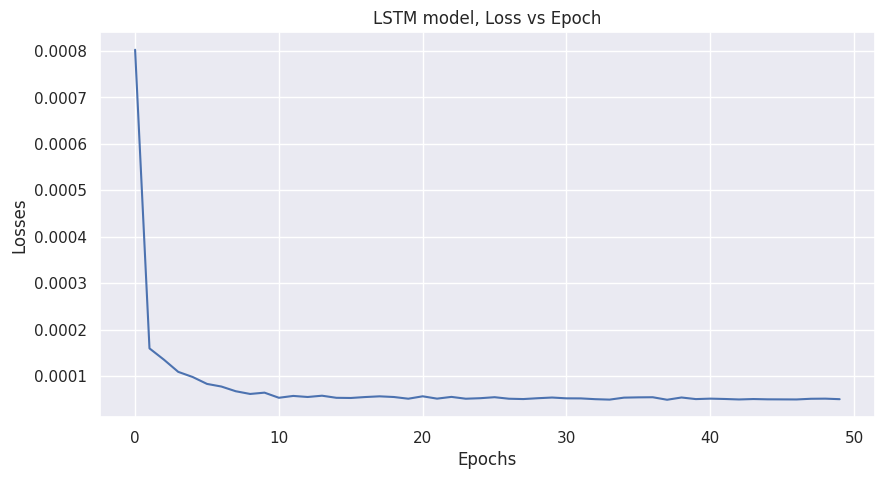

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(lstm_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

In [ ]:
predicted_data_valid2=model1.predict(X_valid)
predicted_data_valid2=min_max_scaler.inverse_transform(predicted_data_valid2)

10/10 [==============================] - 0s 3ms/step


In [ ]:
rmse = np.sqrt(np.mean(((predicted_data_valid2 - y_valid) ** 2)))
print("rmse validation set: ", rmse)

rmse validation set:  2.8575235058131754


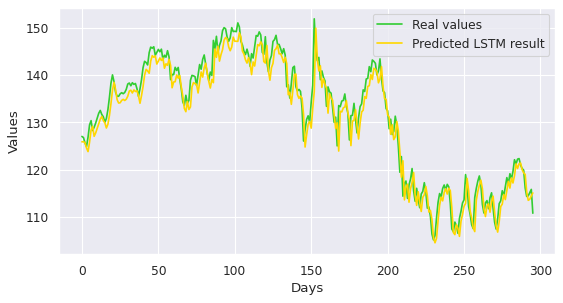

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="LimeGreen",label="Real values")
plt.plot(predicted_data_valid2,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# Comparetive Study of RNN predictions and LSTM predictions

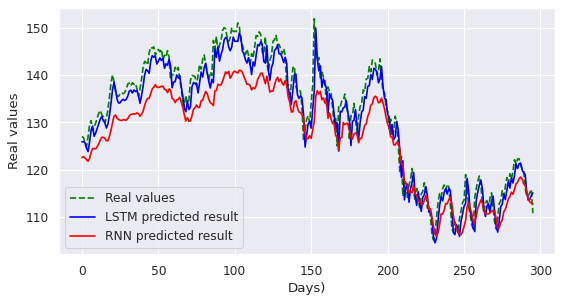

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="green", linestyle='dashed',label="Real values")
plt.plot(predicted_data_valid2,color="blue", label="LSTM predicted result")
plt.plot(predicted_data_valid,color="red",label="RNN predicted result") #
plt.legend()
plt.xlabel("Days)")
plt.ylabel("Real values")
plt.grid(True)
plt.show()

Applying the best model to test set

In [ ]:
predicted_test=model1.predict(X_test)
predicted_test=min_max_scaler.inverse_transform(predicted_test)
y_test = min_max_scaler.inverse_transform(y_test)

10/10 [==============================] - 0s 3ms/step


In [ ]:
rmse = np.sqrt(np.mean(((predicted_test - y_test) ** 2)))
print("rmse validation set: ", rmse)

rmse validation set:  2.358287734946266


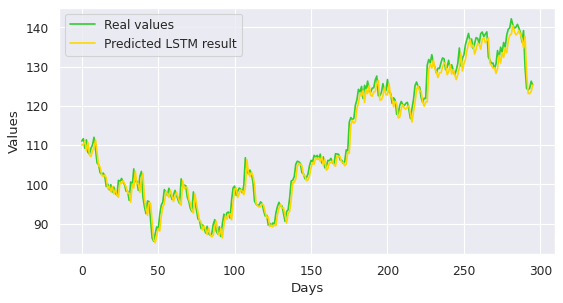

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test,color="LimeGreen",label="Real values")
plt.plot(predicted_test,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()